# Calculating the Max and the Min mixed layer depth 
Monthly mean (top) maximum and (bottom) minimum mixed layer depths from the CESM during the 1990s are compared with observed mixed layer depths from the WOA2009 (Locarnini et al. 2010; Antonov et al. 2010). Mixed layer depths were calculated from annual mean density fields as the depth where the density difference from surface waters exceeded 0.125 g L21.

Stock et al. 2014 global -- Mixed layer depth calculations are based on a density difference threshold relative to the surface of 0.03 kg m-3

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns

In [2]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [4]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

## Import 20 year climatology from 1990-2009 

In [5]:
path = '/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/GNG595_2ndcycle_1990-2009_clim'
files = sorted(glob.glob(f'{path}/*.nc', recursive=True),key=numericalSort)
ds= xr.open_mfdataset(files,combine='by_coords')

    Large et al, JPO, Vol 27 (1997):2418- defined the mixed layer as :The discrete model profile of buoyancy b(k) at depth -z(k) is scanned for the maximum of (b(k)-b(1))*z(k)^(-1), where the first level buoyancy b(1) is equated to the surface buoyance. The mixed layer depth h(m1) is then shallowest depth where the local , interpolated buoyancy gradient equals this maximum.

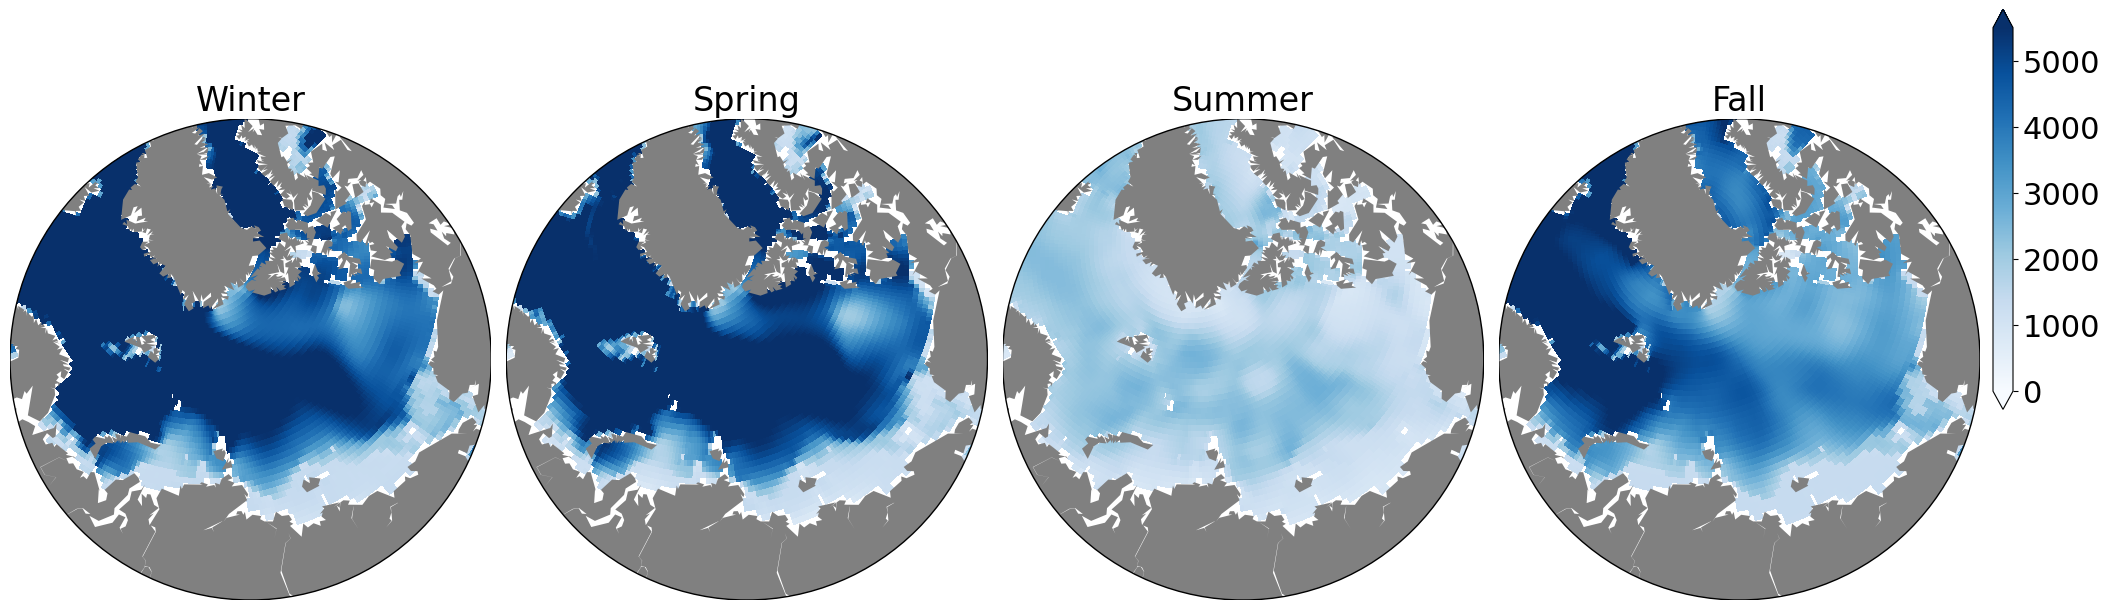

In [6]:
from mpl_toolkits.basemap import Basemap
#lev = np.arange(0, 1, 0.01)
#norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)
fig = plt.figure(figsize=(20, 10))
vminn= 0 
vmaxx=5500
# Winter TLeq = 3 (62yr average)
ax = fig.add_subplot(1, 4, 1)
lon, lat, winter = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(ds.HMXL[list(range(2)) + [-1],:,:],axis=(0)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, winter, cmap='Blues', vmin = vminn, vmax = vmaxx);
ax.set_title('Winter', fontsize =24)

# Spring TLeq = 3, (62yr average)
ax = fig.add_subplot(1, 4, 2)
lon, lat, spring = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(ds.HMXL[2:5,:,:],axis=(0)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, spring, cmap='Blues', vmin = vminn, vmax = vmaxx);
ax.set_title('Spring', fontsize =24)

# Summer TLeq = 3, (62 yr average)
ax = fig.add_subplot(1, 4, 3)
lon, lat, summer = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(ds.HMXL[5:8,:,:],axis=(0)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, summer, cmap='Blues', vmin = vminn, vmax = vmaxx);
ax.set_title('Summer', fontsize =24)

# Fall TLeq = 3, (62 yr average)
ax = fig.add_subplot(1, 4, 4)
lon, lat, fall = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(ds.HMXL[8:11,:,:],axis=(0)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, fall, cmap='Blues',vmin = vminn, vmax = vmaxx);
ax.set_title('Fall', fontsize =24)
cbar_ax = fig.add_axes([0.999, 0.45, 0.01, 0.4])
cb = fig.colorbar(cf, shrink=1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=22)

fig.tight_layout()
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/AO_hxml_cm_20yrclim_final.png',dpi=600, bbox_inches='tight')

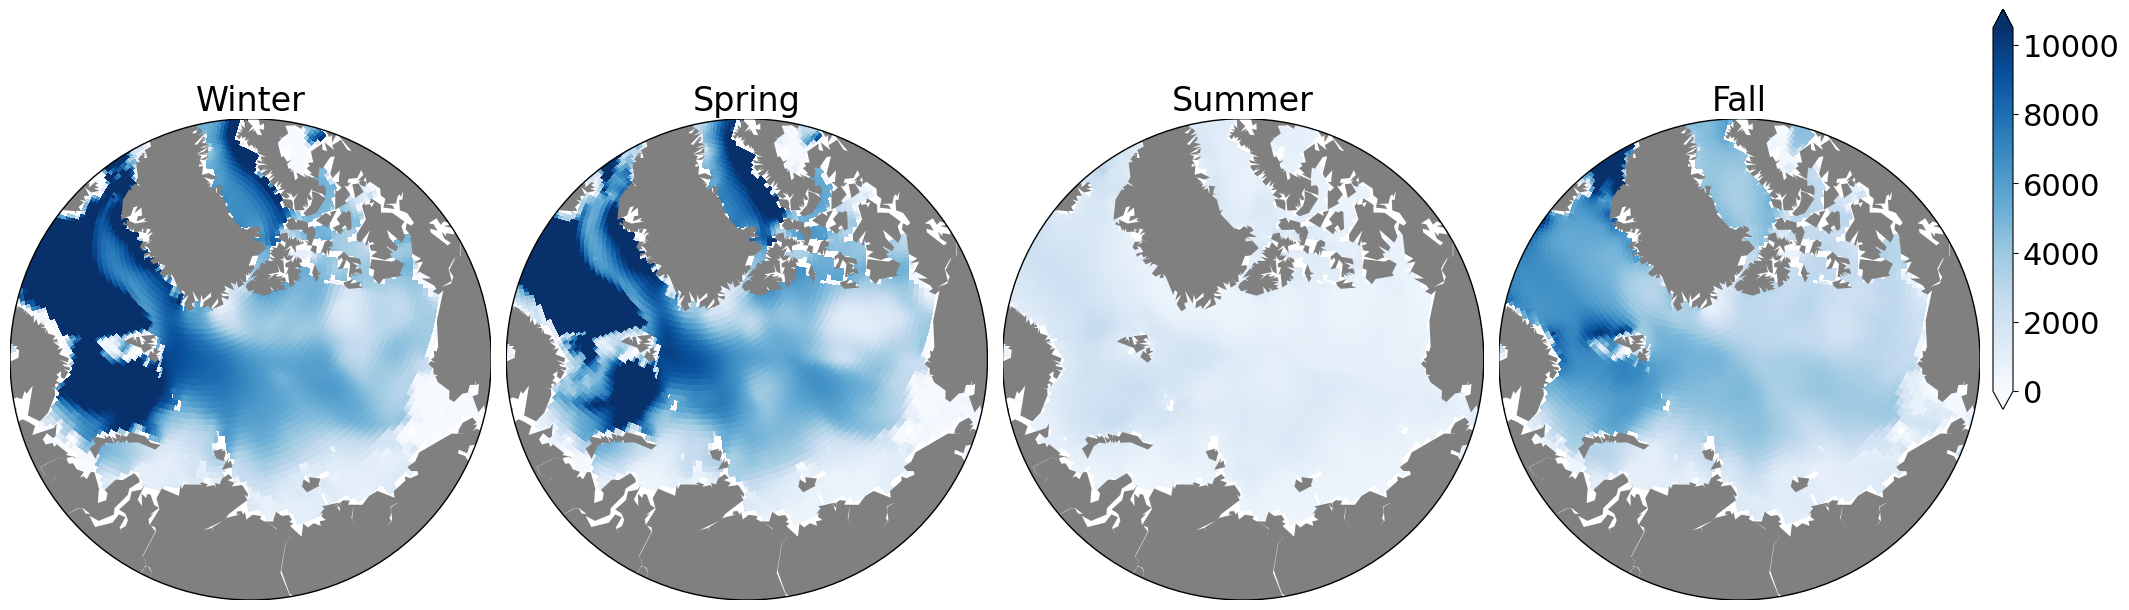

In [55]:
from mpl_toolkits.basemap import Basemap
#lev = np.arange(0, 1, 0.01)
#norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)
fig = plt.figure(figsize=(20, 10))
vminn= 0 
vmaxx=10500
# Winter TLeq = 3 (62yr average)
ax = fig.add_subplot(1, 4, 1)
lon, lat, winter = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(ds.HMXL_DR[list(range(2)) + [-1],:,:],axis=(0)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, winter, cmap='Blues', vmin = vminn, vmax = vmaxx);
ax.set_title('Winter', fontsize =24)

# Spring TLeq = 3, (62yr average)
ax = fig.add_subplot(1, 4, 2)
lon, lat, spring = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(ds.HMXL_DR[2:5,:,:],axis=(0)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, spring, cmap='Blues', vmin = vminn, vmax = vmaxx);
ax.set_title('Spring', fontsize =24)

# Summer TLeq = 3, (62 yr average)
ax = fig.add_subplot(1, 4, 3)
lon, lat, summer = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(ds.HMXL_DR[5:8,:,:],axis=(0)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, summer, cmap='Blues', vmin = vminn, vmax = vmaxx);
ax.set_title('Summer', fontsize =24)

# Fall TLeq = 3, (62 yr average)
ax = fig.add_subplot(1, 4, 4)
lon, lat, fall = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(ds.HMXL_DR[8:11,:,:],axis=(0)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, fall, cmap='Blues',vmin = vminn, vmax = vmaxx);
ax.set_title('Fall', fontsize =24)
cbar_ax = fig.add_axes([0.999, 0.45, 0.01, 0.4])
cb = fig.colorbar(cf, shrink=1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=22)

fig.tight_layout()
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/AO_hxmld_cm_20yrclim_final.png',dpi=600, bbox_inches='tight')

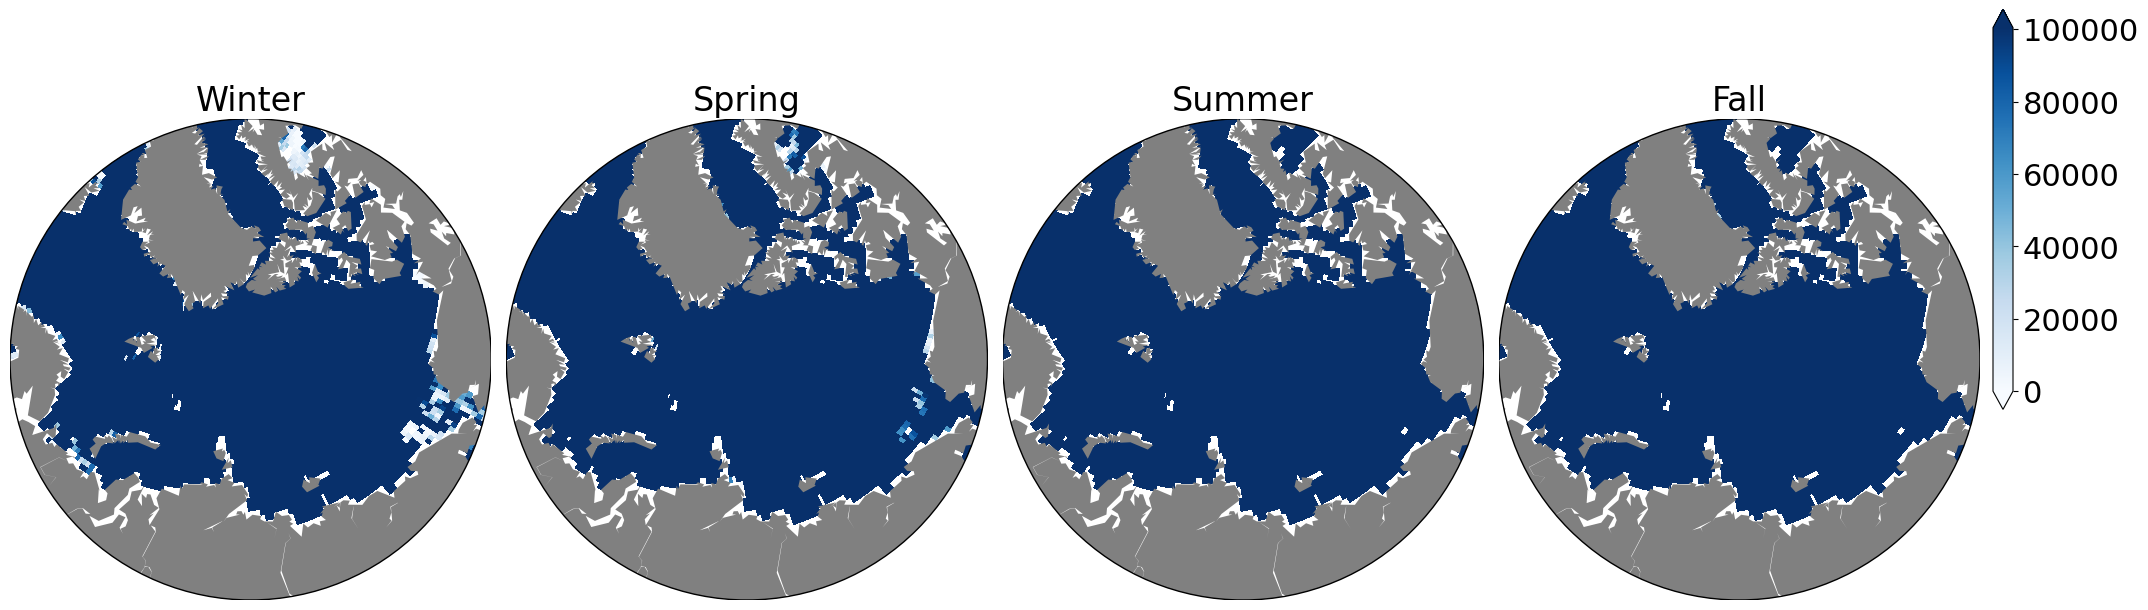

In [57]:
from mpl_toolkits.basemap import Basemap
#lev = np.arange(0, 1, 0.01)
#norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)
fig = plt.figure(figsize=(20, 10))
vminn= 0 
vmaxx=100500
# Winter TLeq = 3 (62yr average)
ax = fig.add_subplot(1, 4, 1)
lon, lat, winter = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(ds.HMXL_DR2[list(range(2)) + [-1],:,:],axis=(0)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, winter, cmap='Blues', vmin = vminn, vmax = vmaxx);
ax.set_title('Winter', fontsize =24)

# Spring TLeq = 3, (62yr average)
ax = fig.add_subplot(1, 4, 2)
lon, lat, spring = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(ds.HMXL_DR2[2:5,:,:],axis=(0)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, spring, cmap='Blues', vmin = vminn, vmax = vmaxx);
ax.set_title('Spring', fontsize =24)

# Summer TLeq = 3, (62 yr average)
ax = fig.add_subplot(1, 4, 3)
lon, lat, summer = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(ds.HMXL_DR2[5:8,:,:],axis=(0)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, summer, cmap='Blues', vmin = vminn, vmax = vmaxx);
ax.set_title('Summer', fontsize =24)

# Fall TLeq = 3, (62 yr average)
ax = fig.add_subplot(1, 4, 4)
lon, lat, fall = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(ds.HMXL_DR2[8:11,:,:],axis=(0)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, fall, cmap='Blues',vmin = vminn, vmax = vmaxx);
ax.set_title('Fall', fontsize =24)
cbar_ax = fig.add_axes([0.999, 0.45, 0.01, 0.4])
cb = fig.colorbar(cf, shrink=1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=22)

fig.tight_layout()
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/AO_hxmld2_cm_20yrclim_final.png',dpi=600, bbox_inches='tight')

In [7]:
## Now import all of the years to create an interannual plot on how the mixed layer depth might change?
from glob import glob

In [8]:
case = 'g.e21.G1850ECOIAF.t62_g17.marbl0_33.GNG595'
path = f'/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/{case}/ocn/hist'

variables = [f'{var}' for var in ['HMXL_DR2','HMXL_DR','HMXL']]
coords = {'x':'TLONG','y':'TLAT'}
keep_vars = variables + list(coords.values())+['dz','KMT','time']

In [9]:
%%time

ds_summer_avg = xr.Dataset()
ds_spring_avg = xr.Dataset()
ds_fall_avg = xr.Dataset()
ds_winter_avg =xr.Dataset()

for year in np.arange(63,125,1):
    yr4="0{:02d}".format(year).zfill(4)
    print(year)
    
    ds_summer = xr.Dataset()
    ds_spring = xr.Dataset()
    ds_winter = xr.Dataset()
    ds_fall = xr.Dataset()

    file = sorted(glob(f'{path}/{case}.pop.h.{yr4}-*.nc'))
    
    winter_indexes = [0,1,-1]
    winter_files = [file[ind] for ind in winter_indexes]
    dsv_winter=xr.open_mfdataset(winter_files, decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
        
    dsv_summer=xr.open_mfdataset(file[5:8], decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    dsv_spring=xr.open_mfdataset(file[2:5], decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    dsv_fall=xr.open_mfdataset(file[8:11], decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    
    for vv in variables: 
        ds_summer = xr.merge((ds_summer, dsv_summer[vv]))
        ds_spring = xr.merge((ds_spring, dsv_spring[vv]))
        ds_winter = xr.merge((ds_winter, dsv_winter[vv]))
        ds_fall = xr.merge((ds_fall, dsv_fall[vv]))
        

    ds_summer = ds_summer.drop([v for v in ds_summer.variables if v not in keep_vars]).squeeze()
    ds_summer = ds_summer.mean(dim='time')
    ds_summer_avg = xr.concat([ds_summer_avg, ds_summer],dim='year')
    
    ds_spring = ds_spring.drop([v for v in ds_spring.variables if v not in keep_vars]).squeeze()
    ds_spring = ds_spring.mean(dim='time')
    ds_spring_avg = xr.concat([ds_spring_avg, ds_spring],dim='year')
    
    ds_winter = ds_winter.drop([v for v in ds_winter.variables if v not in keep_vars]).squeeze()
    ds_winter = ds_winter.mean(dim='time')
    ds_winter_avg = xr.concat([ds_winter_avg, ds_winter],dim='year')
    
    ds_fall = ds_fall.drop([v for v in ds_fall.variables if v not in keep_vars]).squeeze()
    ds_fall = ds_fall.mean(dim='time')
    ds_fall_avg = xr.concat([ds_fall_avg, ds_fall],dim='year')

63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
CPU times: user 10min 4s, sys: 1min 4s, total: 11min 8s
Wall time: 12min 29s


In [10]:
%%time
temp_ds_inter = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/nc_files/temp_ds_inter_surface.nc');

CPU times: user 9.85 ms, sys: 4.27 ms, total: 14.1 ms
Wall time: 67.1 ms


	NC4_open: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/temp_ds_inter_surface.nc mode 4096 params 0
	HDF5 error messages turned on.
			nc4_open_file: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/temp_ds_inter_surface.nc mode 4096
			nc4_grp_list_add: name / 
			nc4_rec_read_metadata: grp->hdr.name /
			found dataset time
			found dataset nlat
			found dataset nlon
			found dataset month
			found dataset TLAT
			found dataset TLONG
			found dataset TEMP
ERROR: Invalid _NCProperties attribute
		*** NetCDF-4 Internal Metadata: int_ncid 0x780000 ext_ncid 0x780000
		FILE - path: /glade/u/home/gabyn/scratch/SPECTRA/nc_files/temp_ds_inter_surface.nc cmode: 0x1008 parallel: 0 redef: 0 fill_mode: 0 no_write: 1 next_nc_grpid: 1
		 GROUP - / nc_grpid: 0 nvars: 5 natts: 0
		 DIMENSION - dimid: 0 name: time len: 62 unlimited: 0
		 DIMENSION - dimid: 2 name: nlat len: 384 unlimited: 0
		 DIMENSION - dimid: 3 name: nlon len: 320 unlimited: 0
		 DIMENSION - dimid: 1 name: month len: 12 unlim

In [11]:
## Calculate climatology for each grid cell
temp_ao_clim = np.nanmean(temp_ds_inter.TEMP,axis=0) # Size (384,320)
temp_ds = np.array(temp_ds_inter.TEMP)

nq_dim: ncid 0x780000 dimid 0
		NC4_inq_dim: ncid 0x780000 dimid 0
		NC4_inq_var_all: ncid 0x780000 varid 1
		NC4_inq_var_all: ncid 0x780000 varid 1
		NC4_inq_dim: ncid 0x780000 dimid 1
		NC4_inq_var_all: ncid 0x780000 varid 1
		NC4_inq_var_all: ncid 0x780000 varid 1
		NC4_inq_dim: ncid 0x780000 dimid 1
		NC4_inq_dim: ncid 0x780000 dimid 1
		NC4_inq_var_all: ncid 0x780000 varid 1
		NC4_inq_var_all: ncid 0x780000 varid 1
		NC4_inq_var_all: ncid 0x780000 varid 1
		NC4_inq_var_all: ncid 0x780000 varid 1
		NC4_inq_var_all: ncid 0x780000 varid 1
		NC4_inq_var_all: ncid 0x780000 varid 1
		NC4_inq_dim: ncid 0x780000 dimid 1
		NC4_inq_dim: ncid 0x780000 dimid 1
		NC4_inq_var_all: ncid 0x780000 varid 2
		NC4_inq_var_all: ncid 0x780000 varid 2
		NC4_inq_dim: ncid 0x780000 dimid 2
		NC4_inq_dim: ncid 0x780000 dimid 3
		NC4_inq_var_all: ncid 0x780000 varid 2
		NC4_inq_var_all: ncid 0x780000 varid 2
		NC4_inq_dim: ncid 0x780000 dimid 2
		NC4_inq_dim: ncid 0x780000 dimid 3
		NC4_inq_dim: ncid 0x7800

In [12]:
%%time
# For every grid cell in the Arctic Ocean 
# Create empty arrays filled with NaN's 
temp_arctic_anom = np.empty([62,12,384,320]) ; temp_arctic_anom[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        temp_arctic_anom[:,:,latitude,longitude] = temp_ds[:,:,latitude,longitude]-temp_ao_clim[:,latitude,longitude]

CPU times: user 1.55 s, sys: 247 ms, total: 1.8 s
Wall time: 1.84 s


In [13]:
%%time
temp_arctic_anom_yearly = np.nanmean(temp_arctic_anom,axis=1) # size is now (62,384,320)

# Create empty arrays filled with NaN's 
pcen_90 = np.empty([384,320]) ; pcen_90[:] = np.nan
pcen_10 = np.empty([384,320]) ; pcen_10[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
    # index of array entry nearest to percentile value
        pcen_90[latitude,longitude]=np.nanpercentile(temp_arctic_anom_yearly[:,latitude,longitude],90,interpolation='nearest')
        pcen_10[latitude,longitude]=np.nanpercentile(temp_arctic_anom_yearly[:,latitude,longitude],10,interpolation='nearest')

CPU times: user 11.2 s, sys: 870 ms, total: 12.1 s
Wall time: 13 s


In [14]:
%%time
# Python3 code to demonstrate working of
# Creating Multidimensional dictionary
# Using defaultdict()
from collections import defaultdict
 
# Utility function to create dictionary
def multi_dict(K, type):
    if K == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: multi_dict(K-1, type))
 
# Initialize dictionary
low_temp_years_arctic = {}
high_temp_years_arctic = {}
 
# Using defaultdict()
# Creating Multidimensional dictionary
# calling function
low_temp_years_arctic = multi_dict(2, int)
high_temp_years_arctic = multi_dict(2, int)
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_temp_years_arctic[latitude][longitude] = np.where(temp_arctic_anom_yearly[:,latitude,longitude] < pcen_10[latitude,longitude])
        high_temp_years_arctic[latitude][longitude] = np.where(temp_arctic_anom_yearly[:,latitude,longitude] > pcen_90[latitude,longitude])

CPU times: user 694 ms, sys: 12.2 ms, total: 706 ms
Wall time: 738 ms


In [15]:
zooTL_summer = np.array(ds_summer_avg.HMXL_DR)
zooTL_spring = np.array(ds_spring_avg.HMXL_DR)
zooTL_witner = np.array(ds_winter_avg.HMXL_DR)
zooTL_fall = np.array(ds_fall_avg.HMXL_DR)

	NC4_close: ncid 0x780000
			nc4_close_hdf5_file: h5->path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/temp_ds_inter_surface.nc abort 0
			nc4_rec_grp_HDF5_del: grp->name /
			closing HDF5 dataset 360287970189639680
			closing HDF5 dataset 360287970189639683
			closing HDF5 dataset 360287970189639684
			closing HDF5 dataset 360287970189639687
			closing HDF5 dataset 360287970189639690
			nc4_close_netcdf4_file: h5->path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/temp_ds_inter_surface.nc abort 0
			nc4_rec_grp_del: grp->name /
			att_free: name _FillValue 
			att_free: name long_name 
			att_free: name units 
			att_free: name missing_value 
			att_free: name _FillValue 
			att_free: name long_name 
			att_free: name units 
			att_free: name missing_value 
			att_free: name _FillValue 
			att_free: name description 
			att_free: name units 
			att_free: name coordinates 


In [16]:
zooTL_summer.shape

(62, 384, 320)

In [17]:
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
low_temp_years_summer = np.empty([384,320]) ; low_temp_years_summer[:] = np.nan
high_temp_years_summer = np.empty([384,320]) ; high_temp_years_summer[:] = np.nan

low_temp_years_spring = np.empty([384,320]) ; low_temp_years_spring[:] = np.nan
high_temp_years_spring = np.empty([384,320]) ; high_temp_years_spring[:] = np.nan

low_temp_years_fall = np.empty([384,320]) ; low_temp_years_fall[:] = np.nan
high_temp_years_fall = np.empty([384,320]) ; high_temp_years_fall[:] = np.nan

low_temp_years_winter = np.empty([384,320]) ; low_temp_years_winter[:] = np.nan
high_temp_years_winter = np.empty([384,320]) ; high_temp_years_winter[:] = np.nan
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_temp_years_summer[latitude,longitude] = np.nanmean(zooTL_summer[low_temp_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))
        high_temp_years_summer[latitude,longitude] = np.nanmean(zooTL_summer[high_temp_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 

        low_temp_years_spring[latitude,longitude] = np.nanmean(zooTL_spring[low_temp_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_temp_years_spring[latitude,longitude]= np.nanmean(zooTL_spring[high_temp_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 

        low_temp_years_fall[latitude,longitude] = np.nanmean(zooTL_witner[low_temp_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_temp_years_fall[latitude,longitude] = np.nanmean(zooTL_witner[high_temp_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))

        low_temp_years_winter[latitude,longitude]= np.nanmean(zooTL_fall[low_temp_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_temp_years_winter[latitude,longitude] = np.nanmean(zooTL_fall[high_temp_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
 

In [ ]:
%%time
ECOSYS_IFRAC_ds_inter = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/nc_files/ECOSYS_IFRAC_ds_inter_surface.nc');

CPU times: user 8.06 ms, sys: 4.98 ms, total: 13 ms
Wall time: 108 ms


In [ ]:
## Calculate climatology for each grid cell
ice_ao_clim = np.nanmean(ECOSYS_IFRAC_ds_inter.ECOSYS_IFRAC,axis=0) # Size (12,384,320)
ECOSYS_IFRAC_ds = np.array(ECOSYS_IFRAC_ds_inter.ECOSYS_IFRAC)

In [ ]:
%%time
# For every grid cell in the Arctic Ocean 
# Create empty arrays filled with NaN's 
ice_arctic_anom = np.empty([62,12,384,320]) ; ice_arctic_anom[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        ice_arctic_anom[:,:,latitude,longitude] = ECOSYS_IFRAC_ds[:,:,latitude,longitude]-ice_ao_clim[:,latitude,longitude]

In [21]:
ice_arctic_anom_yearly = np.nanmean(ice_arctic_anom,axis=1) # size is now (62,180,360)

# Create empty arrays filled with NaN's 
pcen_90_ice = np.empty([384,320]) ; pcen_90_ice[:] = np.nan
pcen_10_ice = np.empty([384,320]) ; pcen_10_ice[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
    # index of array entry nearest to percentile value
        pcen_90_ice[latitude,longitude]=np.nanpercentile(ice_arctic_anom_yearly[:,latitude,longitude],90,interpolation='nearest')
        pcen_10_ice[latitude,longitude]=np.nanpercentile(ice_arctic_anom_yearly[:,latitude,longitude],10,interpolation='nearest')

In [22]:
# Python3 code to demonstrate working of
# Creating Multidimensional dictionary
# Using defaultdict()
from collections import defaultdict
 
# Utility function to create dictionary
def multi_dict(K, type):
    if K == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: multi_dict(K-1, type))
 
# Initialize dictionary
low_ice_years_arctic = {}
high_ice_years_arctic = {}
 
# Using defaultdict()
# Creating Multidimensional dictionary
# calling function
low_ice_years_arctic = multi_dict(2, int)
high_ice_years_arctic = multi_dict(2, int)
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_ice_years_arctic[latitude][longitude] = np.where(ice_arctic_anom_yearly[:,latitude,longitude] < pcen_10_ice[latitude,longitude])
        high_ice_years_arctic[latitude][longitude] = np.where(ice_arctic_anom_yearly[:,latitude,longitude] > pcen_90_ice[latitude,longitude])

In [23]:
%%time
# Loop through the latitudes and longitudes to calculate anomalies and error values.
low_ice_years_summer = np.empty([384,320]) ; low_ice_years_summer[:] = np.nan
high_ice_years_summer = np.empty([384,320]) ; high_ice_years_summer[:] = np.nan

low_ice_years_spring = np.empty([384,320]) ; low_ice_years_spring[:] = np.nan
high_ice_years_spring = np.empty([384,320]) ; high_ice_years_spring[:] = np.nan

low_ice_years_fall = np.empty([384,320]) ; low_ice_years_fall[:] = np.nan
high_ice_years_fall = np.empty([384,320]) ; high_ice_years_fall[:] = np.nan

low_ice_years_winter = np.empty([384,320]) ; low_ice_years_winter[:] = np.nan
high_ice_years_winter = np.empty([384,320]) ; high_ice_years_winter[:] = np.nan
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_ice_years_summer[latitude,longitude] = np.nanmean(zooTL_summer[low_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))
        high_ice_years_summer[latitude,longitude] = np.nanmean(zooTL_summer[high_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 

        low_ice_years_spring[latitude,longitude] = np.nanmean(zooTL_spring[low_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_ice_years_spring[latitude,longitude]= np.nanmean(zooTL_spring[high_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 

        low_ice_years_fall[latitude,longitude] = np.nanmean(zooTL_fall[low_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_ice_years_fall[latitude,longitude] = np.nanmean(zooTL_fall[high_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))

        low_ice_years_winter[latitude,longitude]= np.nanmean(zooTL_witner[low_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_ice_years_winter[latitude,longitude] = np.nanmean(zooTL_witner[high_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
 

CPU times: user 33.2 s, sys: 3.82 ms, total: 33.2 s
Wall time: 34.6 s


In [24]:
%%time
NO3_ds_inter = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/nc_files/NO3_ds_inter_surface.nc');

CPU times: user 18.9 ms, sys: 0 ns, total: 18.9 ms
Wall time: 120 ms


	NC4_open: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/NO3_ds_inter_surface.nc mode 4096 params 0
	HDF5 error messages turned on.
			nc4_open_file: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/NO3_ds_inter_surface.nc mode 4096
			nc4_grp_list_add: name / 
			nc4_rec_read_metadata: grp->hdr.name /
			found dataset time
			found dataset nlat
			found dataset nlon
			found dataset month
			found dataset TLAT
			found dataset TLONG
			found dataset NO3
ERROR: Invalid _NCProperties attribute
		*** NetCDF-4 Internal Metadata: int_ncid 0x510000 ext_ncid 0x510000
		FILE - path: /glade/u/home/gabyn/scratch/SPECTRA/nc_files/NO3_ds_inter_surface.nc cmode: 0x1008 parallel: 0 redef: 0 fill_mode: 0 no_write: 1 next_nc_grpid: 1
		 GROUP - / nc_grpid: 0 nvars: 5 natts: 0
		 DIMENSION - dimid: 0 name: time len: 62 unlimited: 0
		 DIMENSION - dimid: 2 name: nlat len: 384 unlimited: 0
		 DIMENSION - dimid: 3 name: nlon len: 320 unlimited: 0
		 DIMENSION - dimid: 1 name: month len: 12 unlimited

In [25]:
%%time
## Calculate climatology for each grid cell
no3_ao_clim = np.nanmean(NO3_ds_inter.NO3,axis=0) # Size (12,384,320)

		NC4_inq_var_all: ncid 0x510000 varid 4
		NC4_inq_var_all: ncid 0x510000 varid 4
		NC4_inq_dim: ncid 0x510000 dimid 0
		NC4_inq_dim: ncid 0x510000 dimid 1
		NC4_inq_dim: ncid 0x510000 dimid 2
		NC4_inq_dim: ncid 0x510000 dimid 3
		NC4_inq_dim: ncid 0x510000 dimid 0
		NC4_inq_dim: ncid 0x510000 dimid 1
		NC4_inq_dim: ncid 0x510000 dimid 2
		NC4_inq_dim: ncid 0x510000 dimid 3
		NC4_inq_var_all: ncid 0x510000 varid 4
		NC4_inq_var_all: ncid 0x510000 varid 4
		NC4_inq_dim: ncid 0x510000 dimid 0
		NC4_inq_dim: ncid 0x510000 dimid 1
		NC4_inq_dim: ncid 0x510000 dimid 2
		NC4_inq_dim: ncid 0x510000 dimid 3
		NC4_inq_var_all: ncid 0x510000 varid 4
		NC4_inq_var_all: ncid 0x510000 varid 4
		NC4_inq_dim: ncid 0x510000 dimid 0
		NC4_inq_dim: ncid 0x510000 dimid 1
		NC4_inq_dim: ncid 0x510000 dimid 2
		NC4_inq_dim: ncid 0x510000 dimid 3
		NC4_inq_var_all: ncid 0x510000 varid 4
			NC4_get_vars: var->hdr.name NO3 mem_nc_type 6
		NC4_inq_var_all: ncid 0x510000 varid 4
		NC4_inq_var_all: ncid 0x51000

CPU times: user 498 ms, sys: 1.27 s, total: 1.77 s
Wall time: 1.96 s


In [26]:
NO3_ds = np.array(NO3_ds_inter.NO3)

		NC4_inq_var_all: ncid 0x510000 varid 4
		NC4_inq_var_all: ncid 0x510000 varid 4
		NC4_inq_dim: ncid 0x510000 dimid 0
		NC4_inq_dim: ncid 0x510000 dimid 1
		NC4_inq_dim: ncid 0x510000 dimid 2
		NC4_inq_dim: ncid 0x510000 dimid 3
		NC4_inq_dim: ncid 0x510000 dimid 0
		NC4_inq_dim: ncid 0x510000 dimid 1
		NC4_inq_dim: ncid 0x510000 dimid 2
		NC4_inq_dim: ncid 0x510000 dimid 3
		NC4_inq_var_all: ncid 0x510000 varid 4
		NC4_inq_var_all: ncid 0x510000 varid 4
		NC4_inq_dim: ncid 0x510000 dimid 0
		NC4_inq_dim: ncid 0x510000 dimid 1
		NC4_inq_dim: ncid 0x510000 dimid 2
		NC4_inq_dim: ncid 0x510000 dimid 3
		NC4_inq_var_all: ncid 0x510000 varid 4
		NC4_inq_var_all: ncid 0x510000 varid 4
		NC4_inq_dim: ncid 0x510000 dimid 0
		NC4_inq_dim: ncid 0x510000 dimid 1
		NC4_inq_dim: ncid 0x510000 dimid 2
		NC4_inq_dim: ncid 0x510000 dimid 3
		NC4_inq_var_all: ncid 0x510000 varid 4
			NC4_get_vars: var->hdr.name NO3 mem_nc_type 6
		NC4_inq_var_all: ncid 0x510000 varid 4
		NC4_inq_var_all: ncid 0x51000

In [27]:
%%time
# For every grid cell in the Arctic Ocean 
# Create empty arrays filled with NaN's 
no3_arctic_anom = np.empty([62,12,384,320]) ; no3_arctic_anom[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        no3_arctic_anom[:,:,latitude,longitude] = NO3_ds[:,:,latitude,longitude]-no3_ao_clim[:,latitude,longitude]

CPU times: user 1.54 s, sys: 253 ms, total: 1.79 s
Wall time: 1.84 s


In [28]:
%%time
no3_arctic_anom_yearly = np.nanmean(no3_arctic_anom,axis=1) # size is now (62,384,320)

# Create empty arrays filled with NaN's 
pcen_90_no3 = np.empty([384,320]) ; pcen_90_no3[:] = np.nan
pcen_10_no3 = np.empty([384,320]) ; pcen_10_no3[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
    # index of array entry nearest to percentile value
        pcen_90_no3[latitude,longitude]=np.nanpercentile(no3_arctic_anom_yearly[:,latitude,longitude],90,interpolation='nearest')
        pcen_10_no3[latitude,longitude]=np.nanpercentile(no3_arctic_anom_yearly[:,latitude,longitude],10,interpolation='nearest')

CPU times: user 11 s, sys: 907 ms, total: 11.9 s
Wall time: 12.2 s


In [29]:
# Python3 code to demonstrate working of
# Creating Multidimensional dictionary
# Using defaultdict()
from collections import defaultdict
 
# Utility function to create dictionary
def multi_dict(K, type):
    if K == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: multi_dict(K-1, type))
 
# Initialize dictionary
low_no3_years_arctic = {}
high_no3_years_arctic = {}
 
# Using defaultdict()
# Creating Multidimensional dictionary
# calling function
low_no3_years_arctic = multi_dict(2, int)
high_no3_years_arctic = multi_dict(2, int)
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_no3_years_arctic[latitude][longitude] = np.where(no3_arctic_anom_yearly[:,latitude,longitude] < pcen_10_no3[latitude,longitude])
        high_no3_years_arctic[latitude][longitude] = np.where(no3_arctic_anom_yearly[:,latitude,longitude] > pcen_90_no3[latitude,longitude])

In [30]:
%%time
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
low_no3_years_summer = np.empty([384,320]) ; low_no3_years_summer[:] = np.nan
high_no3_years_summer = np.empty([384,320]) ; high_no3_years_summer[:] = np.nan

low_no3_years_spring = np.empty([384,320]) ; low_no3_years_spring[:] = np.nan
high_no3_years_spring = np.empty([384,320]) ; high_no3_years_spring[:] = np.nan

low_no3_years_fall = np.empty([384,320]) ; low_no3_years_fall[:] = np.nan
high_no3_years_fall = np.empty([384,320]) ; high_no3_years_fall[:] = np.nan

low_no3_years_winter = np.empty([384,320]) ; low_no3_years_winter[:] = np.nan
high_no3_years_winter = np.empty([384,320]) ; high_no3_years_winter[:] = np.nan
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_no3_years_summer[latitude,longitude] = np.nanmean(zooTL_summer[low_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))
        high_no3_years_summer[latitude,longitude] = np.nanmean(zooTL_summer[high_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 

        low_no3_years_spring[latitude,longitude] = np.nanmean(zooTL_spring[low_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_no3_years_spring[latitude,longitude]= np.nanmean(zooTL_spring[high_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 

        low_no3_years_fall[latitude,longitude] = np.nanmean(zooTL_fall[low_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_no3_years_fall[latitude,longitude] = np.nanmean(zooTL_fall[high_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))

        low_no3_years_winter[latitude,longitude]= np.nanmean(zooTL_witner[low_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_no3_years_winter[latitude,longitude] = np.nanmean(zooTL_witner[high_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
 

CPU times: user 31.2 s, sys: 218 ms, total: 31.4 s
Wall time: 35.2 s


	NC4_close: ncid 0x460000
			nc4_close_hdf5_file: h5->path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/ECOSYS_IFRAC_ds_inter_surface.nc abort 0
			nc4_rec_grp_HDF5_del: grp->name /
			closing HDF5 dataset 360287970189639695
			closing HDF5 dataset 360287970189639698
			closing HDF5 dataset 360287970189639699
			closing HDF5 dataset 360287970189639702
			closing HDF5 dataset 360287970189639705
			nc4_close_netcdf4_file: h5->path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/ECOSYS_IFRAC_ds_inter_surface.nc abort 0
			nc4_rec_grp_del: grp->name /
			att_free: name history 
			att_free: name NCO 
			att_free: name _FillValue 
			att_free: name long_name 
			att_free: name units 
			att_free: name missing_value 
			att_free: name _FillValue 
			att_free: name long_name 
			att_free: name units 
			att_free: name missing_value 
			att_free: name _FillValue 
			att_free: name description 
			att_free: name units 
			att_free: name coordinates 
	NC4_close: ncid 0x510000
			nc4_close_hdf5_file

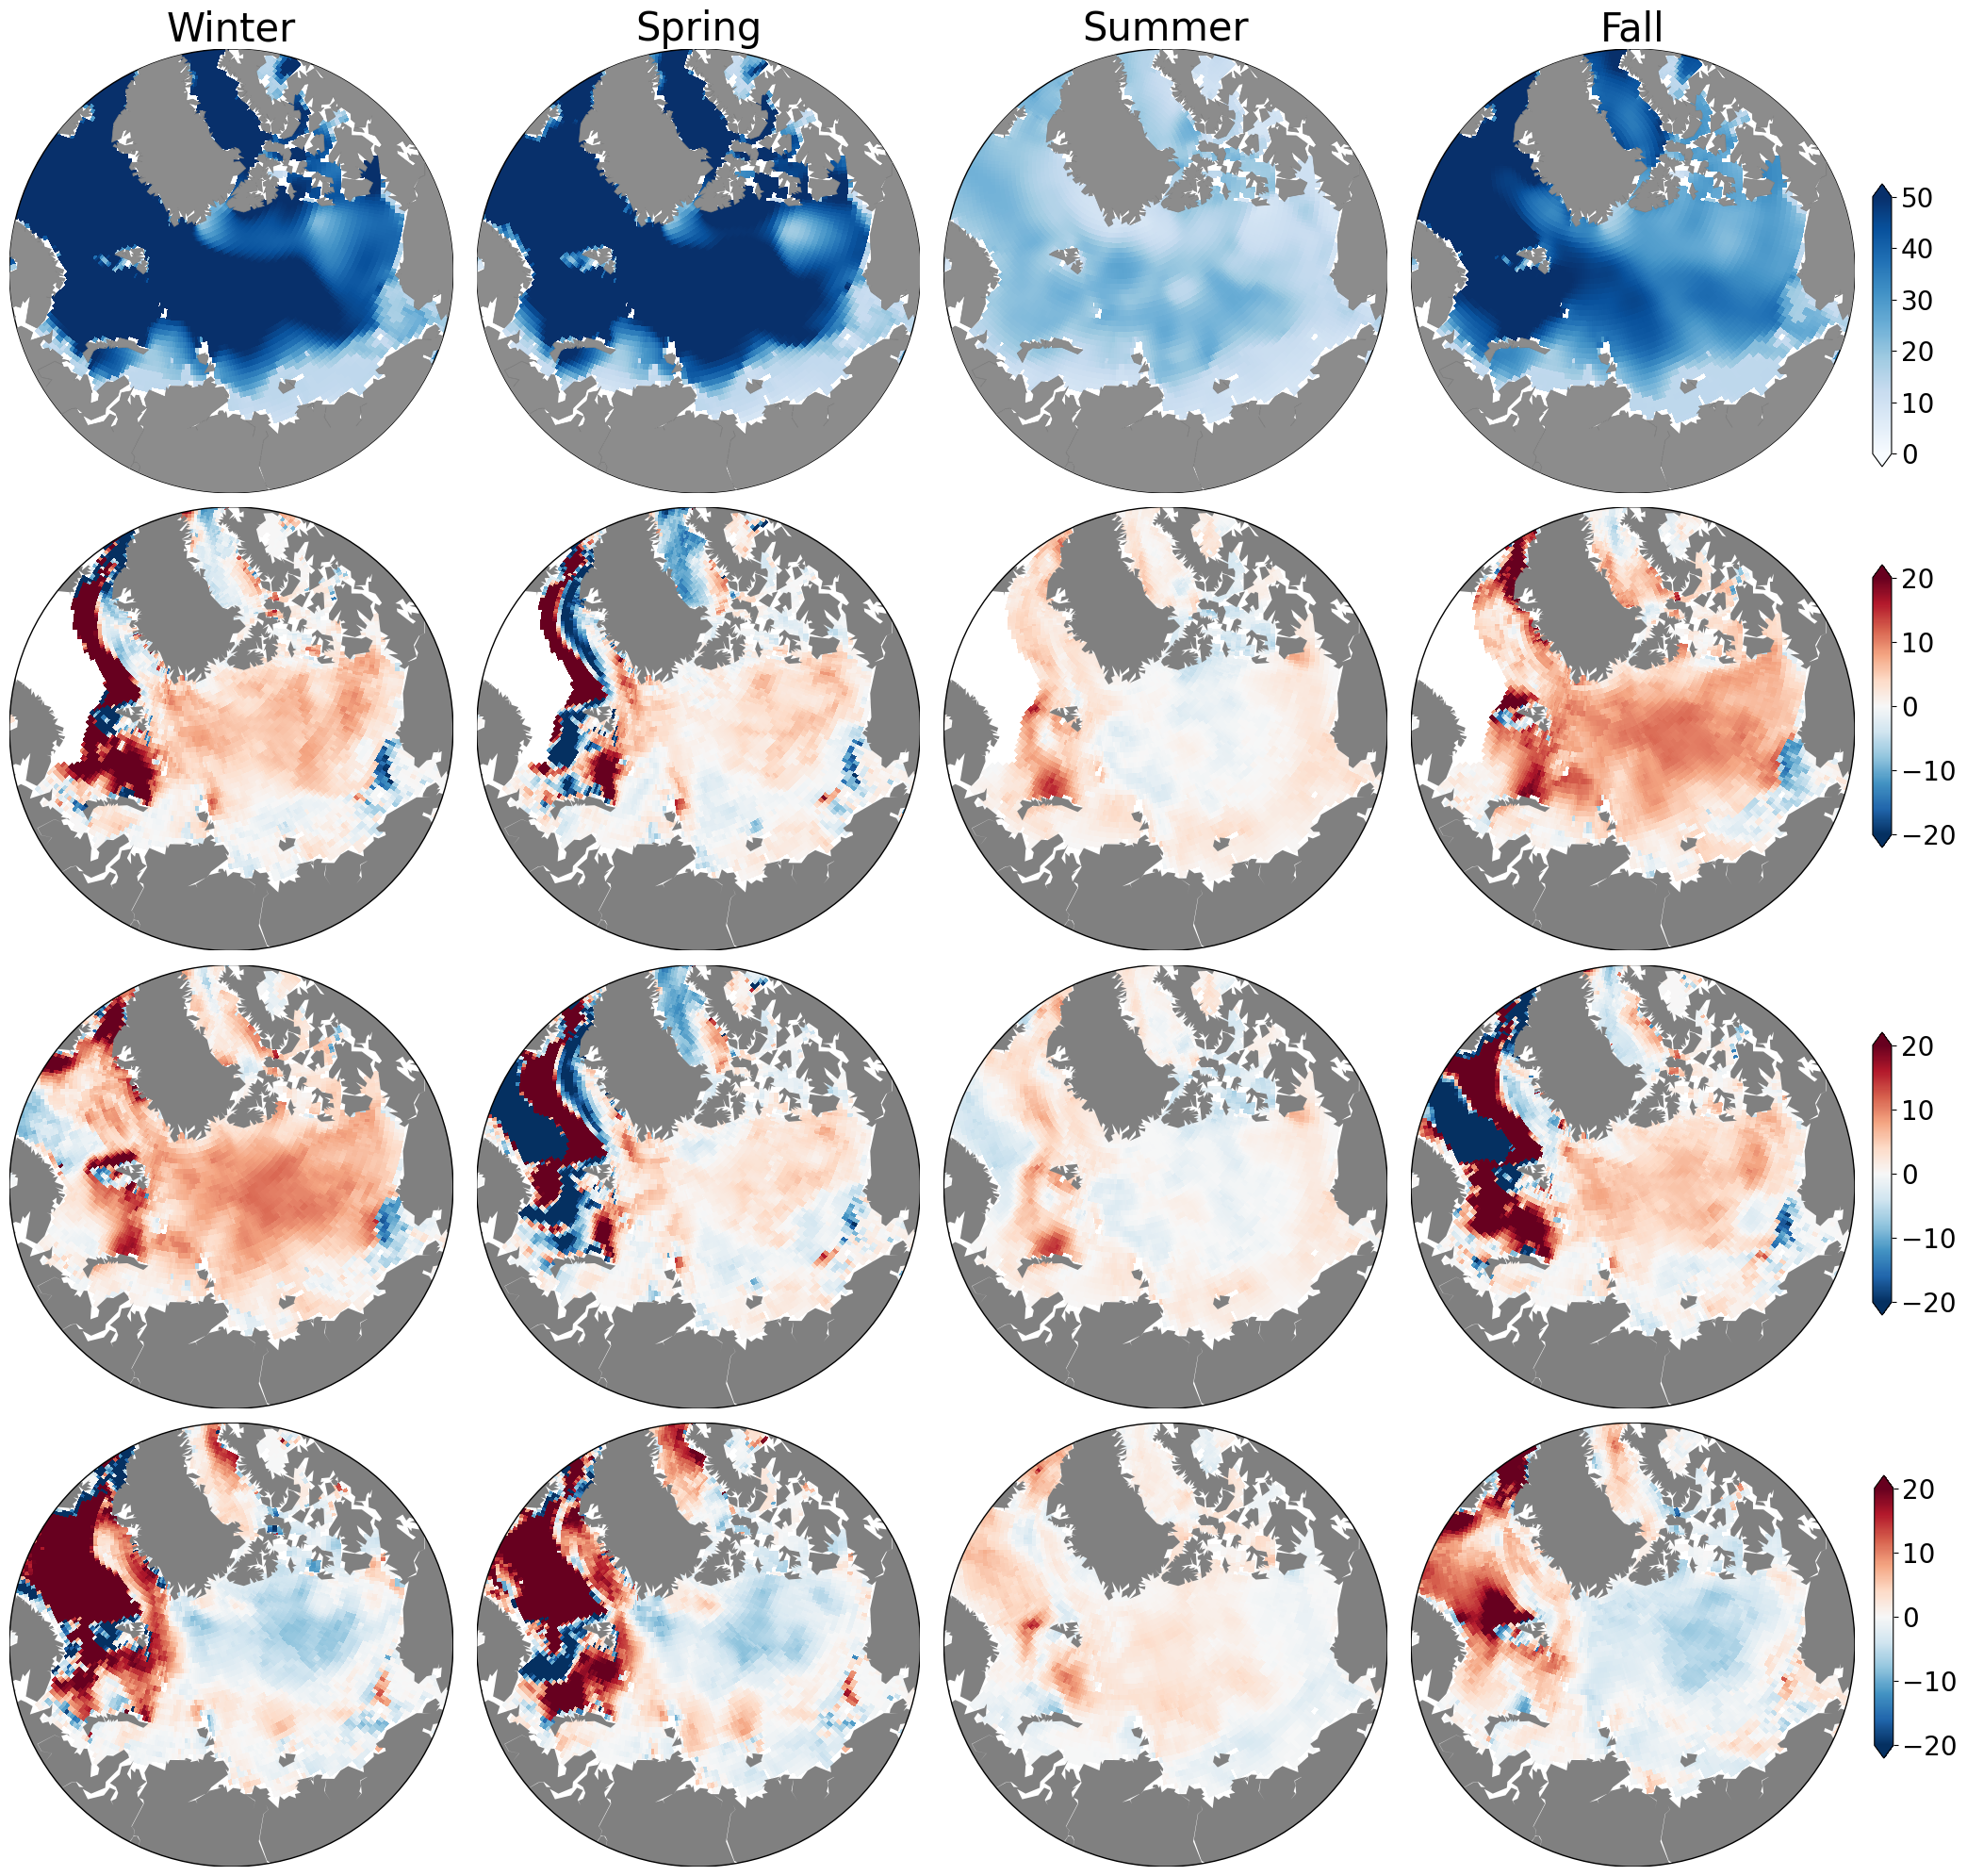

In [31]:
from mpl_toolkits.basemap import Basemap
lev = np.arange(0, 10, 0.05)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=1)
fig = plt.figure(figsize=(20, 20))
vminn=0
vmaxx=50
## WINTER 
ax = fig.add_subplot(4, 4, 1)
lon, lat, winter = adjust_pop_grid(ds.TLONG, ds.TLAT, ds_winter_avg.HMXL.mean(axis=(0))/100)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
x,y = m(lon, lat)
cf = m.pcolor(x,y,winter,cmap='Blues',vmin=vminn, vmax=vmaxx)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Winter', fontsize =30)

## SPRING
ax = fig.add_subplot(4, 4, 2)
lon, lat, spring = adjust_pop_grid(ds.TLONG, ds.TLAT, ds_spring_avg.HMXL.mean(axis=(0))/100)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
x,y = m(lon, lat)
cf = m.pcolor(x,y,spring,cmap='Blues',vmin=vminn, vmax=vmaxx)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Spring', fontsize =30)

## SUMMER
ax = fig.add_subplot(4, 4, 3)
lon, lat, summer = adjust_pop_grid(ds.TLONG, ds.TLAT, ds_summer_avg.HMXL.mean(axis=(0))/100)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
x,y = m(lon, lat)
cf = m.pcolor(x,y,summer,cmap='Blues',vmin=vminn, vmax=vmaxx)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Summer', fontsize =30)


##FALL
ax = fig.add_subplot(4, 4, 4)
lon, lat, fall = adjust_pop_grid(ds.TLONG, ds.TLAT, ds_fall_avg.HMXL.mean(axis=(0))/100)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
x,y = m(lon, lat)
cf = m.pcolor(x,y,fall,cmap='Blues',vmin=vminn, vmax=vmaxx)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Fall', fontsize =30);
cbar_ax = fig.add_axes([0.999, 0.75, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)

########## Differences!!! 
vminn =-20
vmaxx=20
# Winter, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 9)
winter_temp_diff = high_temp_years_winter-low_temp_years_winter
lon, lat, w_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, winter_temp_diff/100)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

# Spring, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 10)
spring_temp_diff = high_temp_years_spring-low_temp_years_spring
lon, lat, sp_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, spring_temp_diff/100)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

# Summer, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 11)
summer_temp_diff = high_temp_years_summer-low_temp_years_summer
lon, lat, s_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, summer_temp_diff/100)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

# Fall, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 12)
fall_temp_diff = high_temp_years_fall-low_temp_years_fall
lon, lat, f_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, fall_temp_diff/100)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cbar_ax = fig.add_axes([0.999, 0.3, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)

## Ice Fraction

# Winter, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 4, 5)
winter_ice_diff = low_ice_years_winter-high_ice_years_winter
lon, lat, w_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, winter_ice_diff/100)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

# Spring, % difference of catch from high and low ice fraction years. 
ax = fig.add_subplot(4, 4, 6)
spring_ice_diff = low_ice_years_spring-high_ice_years_spring
lon, lat, sp_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, spring_ice_diff/100)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

# Summer, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 4, 7)
summer_ice_diff = low_ice_years_summer-high_ice_years_summer
lon, lat, s_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, summer_ice_diff/100)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

# Fall, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 4, 8)
fall_ice_diff = low_ice_years_fall-high_ice_years_fall
lon, lat, f_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, fall_ice_diff/100)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cbar_ax = fig.add_axes([0.999, 0.548, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)


# Winter, % difference of catch from high and low NO$_3$  years. 
ax = fig.add_subplot(4, 4, 13)
winter_no3_diff = high_no3_years_winter-low_no3_years_winter
lon, lat, w_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, winter_no3_diff/100)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cb.ax.tick_params(labelsize=20)

# Spring, % difference of catch from high and low NO$_3$ years. 
ax = fig.add_subplot(4, 4, 14)
spring_no3_diff = high_no3_years_spring-low_no3_years_spring
lon, lat, sp_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, spring_no3_diff/100)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

# Summer, % difference of catch from high and low NO$_3$  years. 
ax = fig.add_subplot(4, 4, 15)
summer_no3_diff = high_no3_years_summer-low_no3_years_summer
lon, lat, s_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, summer_no3_diff/100)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

# Fall, % difference of catch from high and low NO$_3$  years. 
ax = fig.add_subplot(4, 4, 16)
fall_no3_diff = high_no3_years_fall-low_no3_years_fall
lon, lat, f_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, fall_no3_diff/100)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cbar_ax = fig.add_axes([0.9999, 0.065, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)
plt.tight_layout()
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/MLD_seasonal_AO_20year_clim.png', dpi=600, bbox_inches='tight')

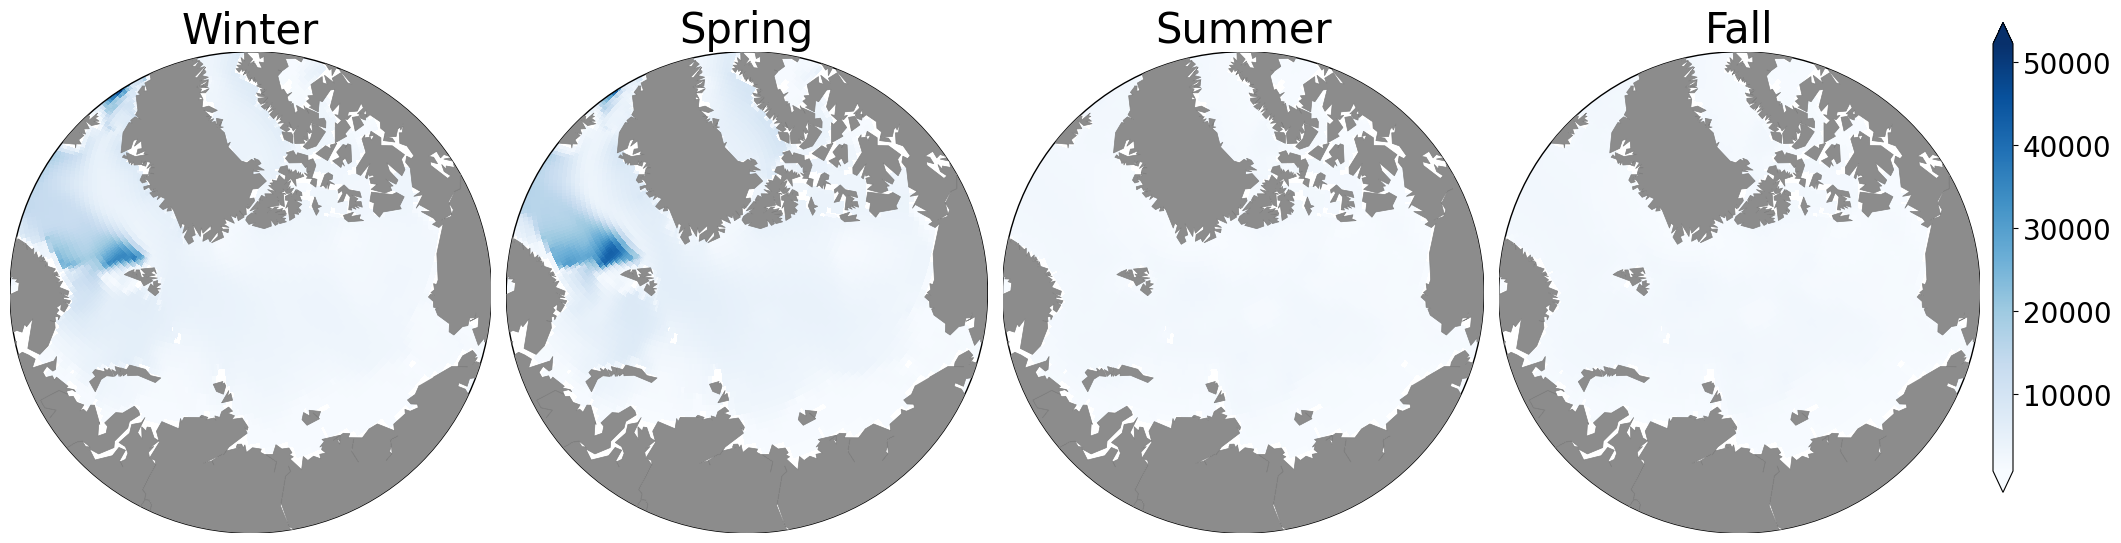

In [96]:
from mpl_toolkits.basemap import Basemap
fig = plt.figure(figsize=(20, 10))
## WINTER 
ax = fig.add_subplot(1, 4, 1)
lon, lat, winter = adjust_pop_grid(ds.TLONG, ds.TLAT, ds_winter_avg.HMXL.mean(axis=(0)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
x,y = m(lon, lat)
cf = m.pcolor(x,y,winter,cmap='Blues')
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Winter', fontsize =30)

## SPRING
ax = fig.add_subplot(1, 4, 2)
lon, lat, spring = adjust_pop_grid(ds.TLONG, ds.TLAT, ds_spring_avg.HMXL.mean(axis=(0)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
x,y = m(lon, lat)
cf = m.pcolor(x,y,spring,cmap='Blues')
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Spring', fontsize =30)

## SUMMER
ax = fig.add_subplot(1, 4, 3)
lon, lat, summer = adjust_pop_grid(ds.TLONG, ds.TLAT, ds_summer_avg.HMXL.mean(axis=(0)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
x,y = m(lon, lat)
cf = m.pcolor(x,y,summer,cmap='Blues')
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Summer', fontsize =30)


##FALL
ax = fig.add_subplot(1, 4, 4)
lon, lat, fall = adjust_pop_grid(ds.TLONG, ds.TLAT, ds_summer_avg.HMXL.mean(axis=(0)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
x,y = m(lon, lat)
cf = m.pcolor(x,y,fall,cmap='Blues')
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Fall', fontsize =30);
cbar_ax = fig.add_axes([0.999, 0.3, 0.01, 0.47])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)
fig.tight_layout()
#fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/TL_seasonal_AO_20year_clim.png', dpi=600, bbox_inches='tight')